[View in Colaboratory](https://colab.research.google.com/github/assaflehr/language-style-transfer/blob/master/notebooks/keras_nlp.ipynb)

>>[Keras accuracy/performace limitations](#scrollTo=Og2XNK-_53VP)

>[Performace caution :](#scrollTo=Og2XNK-_53VP)

>>[Pretraining autoencoder or LM will surely help.](#scrollTo=Og2XNK-_53VP)

>>>[LSTM](#scrollTo=Og2XNK-_53VP)

>>>[Tip to self:](#scrollTo=Og2XNK-_53VP)

>>>[For David: example of how to clone, then use from github](#scrollTo=OrKzdh71sBKm)

>[Some params](#scrollTo=MBAgWVvXycpF)

>[Dataset](#scrollTo=wwc6_EHFD_Ir)

>[Model defintion](#scrollTo=BWVEcaeF6DBR)

>[compile](#scrollTo=VTobPYftYvQC)

>[Sample and show sample](#scrollTo=xh5FwdLGU2n3)

>[TRAINING](#scrollTo=9s0-8EJi6AG1)

>[SAVE LOAD MODEL](#scrollTo=QOjAoPF-gAqx)

>[Error analysis](#scrollTo=XvIkFOWy55ov)

>>[Error of style disc.](#scrollTo=8QaOXXjUAwVH)

>[FAQ and wierd exceptions](#scrollTo=E2yLpQu4mvAS)



## Keras accuracy/performace limitations
 
# Performace caution :
G training epoc (250x64 rows) 

type|RNN|bidi?|time
--|--
CPU|LSTM|Y| 15 min|
GPU|LSTM|Y| 75s| (slower but more-accurate)
GPU|CuDNNLSTM|Y| 42s
GPU|CuDNNLSTM|N| 35s






## Pretraining autoencoder or LM will surely help.

see late review here: https://thegradient.pub/author/sebastian
and autoencoder (which is less recommended than LM here: "Semi-supervised Sequence Learning" 2015. They use one RNN for both encoder and decoder)


###   LSTM 
* CuDNNLSTM trains on GPU , but does not support the attributes: dropout,recurrent_dropout,which are the STOA regulaizers. This is cuda problem, and even native TF does not support it
Hard to compare only that. all G (with dense and more...) takes 35s on GPU. on CPU ???
* Make LSTM deep instead of bigger for linear instead of quadratic growth in compuation. when doing so, add skip connection to 2nd/3rd/... layers
* large vocab size means huge softmax, means slow runtime. to optimize training NCE loss replaces softmax on train-time (TF only)

### Tip to self:
* manually check loss value on one sample (predict vs gt). From doing this, I saw <s> was not given one-hot-value

In [120]:
%load_ext autoreload
%autoreload 2




import tensorflow as tf
import sys
import numpy as np

# colab requirements
!pip install spacy
!pip install pydrive   #to save to google-drive
# our github proj!
!rm -r paraphraser  #remove previous github copy if needed
!git clone https://github.com/delkind/paraphraser.git
sys.path.append('paraphraser/src')





#usage example
from utils.persistency import Persistency    #your code here!!!
from models import D_G_Model

#!ps -ef | grep python




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cloning into 'paraphraser'...
remote: Counting objects: 89, done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 89 (delta 38), reused 71 (delta 24), pack-reused 0
Unpacking objects: 100% (89/89), done.


# Dataset

In [0]:

#dataset = BibleDataset(URL_ROOT, ["asv", "bbe", "dby", "kjv", "wbt", "web", "ylt"], CSV_EXT)
# differences: very old , formal: ylt . very dynamic, simple words: bbe, middle ground (5 similiar wbt)
from dataset.bible import BibleDataset

dataset = BibleDataset(files=["bbe", "ylt"]) 



In [0]:
import keras
from keras.callbacks import ReduceLROnPlateau




batch_size = 64



class LossHistory(keras.callbacks.Callback):
    def __init__(self):
      self.losses = {'loss':[],'val_loss':[]}
      
    #def on_train_begin(self, logs={}):
    #  pass  
    
    def on_epoch_end(self, batch, logs={}):
      for loss in ['loss','val_loss']:
        self.losses[loss].append(logs.get(loss))
        
np.random.seed(42)


import matplotlib.pyplot as plt 

# summarize history for loss
def plt_losses(loss_history,title,with_val=False):
  plt.plot(loss_history.losses['loss'][:])
  if with_val:
    plt.plot(loss_history.losses['val_loss'][:])
  plt.title(title)
  med=0.1 if len(loss_history.losses['loss'])<1 else np.median(loss_history.losses['loss'])
  plt.ylim(ymin=-0.1)
  plt.ylim(ymax=med+1.5)
  plt.ylabel('loss')
  plt.xlabel('batchse')
  plt.legend(['train', 'val'], loc='upper right')
  

def plt_all(with_val=True):  
  plt.figure(figsize=(14,4))
  plt.subplot(131) #numrows, numcols, fignum
  plt_losses(loss_history,'g loss',with_val)  
  plt.subplot(132)
  plt_losses(loss_history_d,'d loss',with_val)  
  plt.subplot(133)
  plt_losses(loss_history_adv,'adv loss',with_val) 
  plt.show()


#  
loss_history = LossHistory()
loss_history_d = LossHistory()
loss_history_adv = LossHistory()  
#plt_all()



def train_g(g, steps, validation_steps=1):
    g.fit_generator(dataset.gen_g(dataset.train, batch_size),
                        steps,
                        validation_steps=validation_steps,
                        validation_data=dataset.gen_g(dataset.val, batch_size),
                        callbacks=[loss_history],
                        verbose=0 if steps < 10 else 1,
                        max_queue_size=50,
                        workers=2
                        )

    # model.fit([x_train, x_train_d], y_train,


def train_d(d, steps, validation_steps=1):
    # %time d_encoder_model.set_weights(encoder_model.get_weights())
    d.fit_generator(dataset.gen_d(dataset.train, batch_size),
                    steps,
                    validation_steps=validation_steps,
                    validation_data=dataset.gen_d(dataset.val, batch_size),
                    verbose=0 if steps < 20 else 1,
                    max_queue_size=50,
                    workers=2,
                    callbacks=[loss_history_d])
    # d.fit(x_train, style_train,


def train_adv(adv_model, steps, validation_steps=1):
    # %time classifier_model.set_weights(d_classifier_model.get_weights())

    adv_model.fit_generator(dataset.gen_adv(dataset.train, batch_size),
                            steps,
                            validation_steps=validation_steps,
                            validation_data=dataset.gen_adv(dataset.val, batch_size),
                            max_queue_size=50,
                            workers=2,
                            verbose=0 if steps < 20 else 1,
                            callbacks=[loss_history_adv])
 
  


In [0]:
from models import D_G_Model

model = D_G_Model(num_encoder_tokens=len(dataset.word2index),
                      num_decoder_tokens=len(dataset.word2index),  #from dataset 3628
                      style_out_size=len(dataset.style2index), #from dataset 2
                      cuddlstm=True,
                      latent_dim = 512, #twice the default. make it stronger! but slower
                      bidi_encoder = True,
                      adv_loss_weight=1.0,)
model.build_all()


  
  

# Sample and show sample

In [136]:
from decoder import SamplingDecoder
sampler= SamplingDecoder(model)        
sampler.show_sample(dataset,'train',sample_ids=[0],teacher_forcing=True)           
#sampler.show_sample(dataset,'val',sample_ids=[0],teacher_forcing=False)

#show_sample('train',sample_id=[0,1,2],teacher_forcing=False) 

# test tokenizer, by looking at the originals:
#orogi https://raw.githubusercontent.com/scrollmapper/bible_databases/master/csv/t_bbe.csv
#At the first God made the heaven and the earth.
#And the earth was waste and without form; and it was dark on the face of the deep: and the Spirit of God was moving on the face of the waters.
#"And God said, Let there be light: and there was light."

#https://raw.githubusercontent.com/scrollmapper/bible_databases/master/csv/t_ylt.csv
#In the beginning of God's preparing the heavens and the earth --
#"the earth hath existed waste and void, and darkness `is' on the face of the deep, and the Spirit of God fluttering on the face of the waters,"
#"and God saith, `Let light be;' and light is."



############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<bbe>]: simon esther simon simon simon sold simon steal steal simon jeshua adversity fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell dwell
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<ylt>]: hireling simon simon undergone riblah wisdom wisdom touch nine carriage worthy shutting jeshua shutting fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship fellowship dwell dwel

# long  pre-TRAINING

epoc is of 755 of batches 64 total train_size 48342
EPOC 0
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder sample [<bbe>]: on the seventh day the lord came about , and the priest will come up and there is no longer come ; <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: from the <OOV> the <OOV> , and the <OOV> is ' <OOV> ; and there is ' jehovah hath come up unto him ; <end>
gold label     [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth

##encoder_input[<ylt>]: in the beginning of god 's <OOV> the heavens and the earth
decoder sample [<bbe>]: in the day of the lord came in the morning and went and said , let him go up and there is no longer . <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: in the ninth year of the <OOV> , and lo hath come in the heavens and 

755/755 [==============================] - 134s 178ms/step - loss: 1.6701 - val_loss: 4.3582


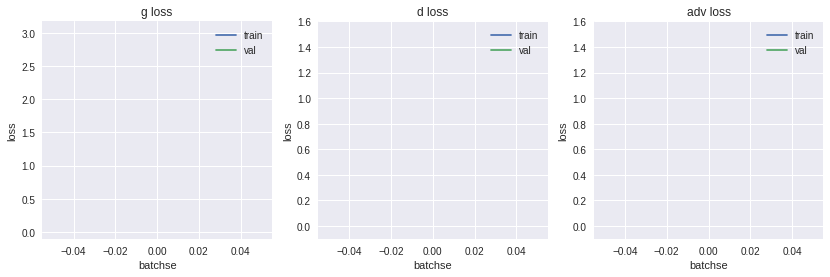

EPOC 1
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder sample [<bbe>]: at the first god the god made them and the earth , and gives them . <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: at the first god the wicked doth the wicked and fall on them , <end>
gold label     [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth

##encoder_input[<ylt>]: in the beginning of god 's <OOV> the heavens and the earth
decoder sample [<bbe>]: in the <OOV> of god 's strength the <OOV> and the earth will overtake him . <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: in the <OOV> of the wicked god of israel and the earth <OOV> them , <end>
gold label     [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth
############################## verb 0 #####################

755/755 [==============================] - 168s 222ms/step - loss: 1.2406 - val_loss: 2.0156


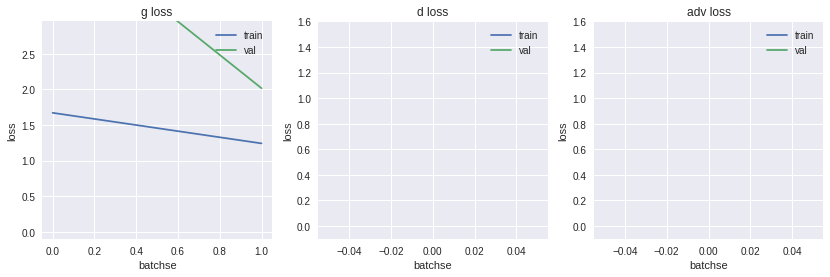

EPOC 2
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder sample [<bbe>]: at the first man the god made , and earth on the earth before the earth as far as god has sent punishment . <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: at the first man the earth on god , and the earth after thee any more hand against the earth before the earth . ' <end>
gold label     [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth

##encoder_input[<ylt>]: in the beginning of god 's <OOV> the heavens and the earth
decoder sample [<bbe>]: in the day of <OOV> in the heart of the heavens and <OOV> me and the earth in mind of the earth , <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: in the day of <OOV> in the heavens of the heavens and <OOV> not keep the back of them , and blessed me 

755/755 [==============================] - 99s 131ms/step - loss: 0.3875 - val_loss: 1.0468


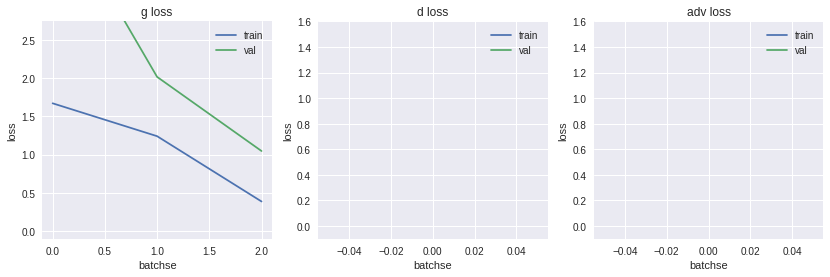

early break at break at 0.38754270957992565 epoc 2


In [139]:
train_size = len(dataset.index2style) * (dataset.train[1] - dataset.train[0])
epoc = int(train_size/batch_size)
print ('epoc is of',epoc,'of batches',batch_size,'total train_size',train_size)


######## PRE TRAINING ##########################

load_id=None
if load_id:
  pers=Persistency()
  pers.load_weights_from(model.get_models(),model.get_model_names(),folder='from_gdrive/',download_gdrive_id=load_id)
  pre_train=False
else:
  pre_train= True
  
if (pre_train):
  for i in range(20):
    print ('EPOC',i)
    train_g(model.g,int(epoc),validation_steps=int(epoc/10))  #pretrain


    l=loss_history.losses['loss'][-1:][0]
    plt_all()
    sampler.show_sample(dataset,'train',[0],teacher_forcing=False) 
    sampler.show_sample(dataset,'train',[0],teacher_forcing=True)
    if l<0.5: #0.5 is good value for 20 length sentences. for longer, NOT!
      print ('early break at break at',l,'epoc',i)
      break
    
  
  for i in range(0):
    train_d(model.d,epoc,validation_steps=100)
    l=loss_history_d.losses['loss'][-1:][0]
    if l<2:
      print ('early break at break at',l,'epoc',i)
      break

  

In [140]:
sampler.show_sample(dataset,'train',[0],teacher_forcing=False) 
sampler.show_sample(dataset,'train',[0],teacher_forcing=True)

############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder sample [<bbe>]: at the first god made the heaven and the earth . <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: at the first god made the heaven and the earth . <end>
gold label     [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth

##encoder_input[<ylt>]: in the beginning of god 's <OOV> the heavens and the earth
decoder sample [<bbe>]: in the past of god 's <OOV> the heavens and the earth <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder sample [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth <end>
gold label     [<ylt>]: in the beginning of god 's <OOV> the heavens and the earth
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and

In [132]:
!pip install pydrive
Persistency().save_weights(model.get_models(),model.get_model_names(),save_to_gdrive=True) #not run yet....

#saving models/models_weights_2018-07-17_18-37-30.zip as id 1_PdK-44BDghnIgQu9ou7MvdquCHvmOt6  

saving models/models_weights_2018-07-17_18-37-30.zip as id 1_PdK-44BDghnIgQu9ou7MvdquCHvmOt6


## Long adverserial training

epoc contains  755 batches of 64
############################## epocs 0
0 of 75 small steps of size 10 please wait... 
20 of 75 small steps of size 10 please wait... 
40 of 75 small steps of size 10 please wait... 
60 of 75 small steps of size 10 please wait... 
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<bbe>]: at the first day made the earth and the earth . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<ylt>]: at the first place the the life the earth and the earth . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <

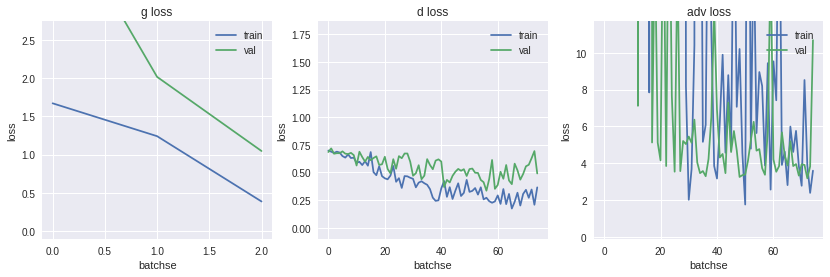

############################## epocs 1
0 of 75 small steps of size 10 please wait... 
20 of 75 small steps of size 10 please wait... 
40 of 75 small steps of size 10 please wait... 
60 of 75 small steps of size 10 please wait... 
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<bbe>]: at the first hour made the earth and the earth . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<ylt>]: at the first first the the life how earth and was earth . . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <

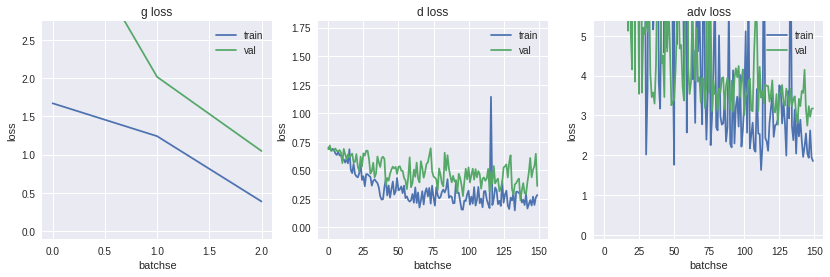

############################## epocs 2
0 of 75 small steps of size 10 please wait... 
20 of 75 small steps of size 10 please wait... 
40 of 75 small steps of size 10 please wait... 
60 of 75 small steps of size 10 please wait... 
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<bbe>]: at the first writing made the sinner and the earth . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<ylt>]: at the first place life those life things earth and those earth . . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <

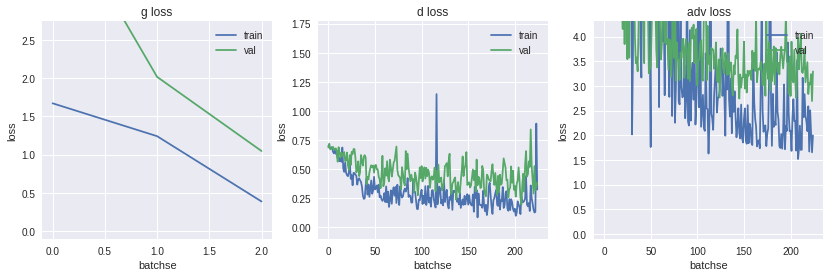

############################## epocs 3
0 of 75 small steps of size 10 please wait... 
20 of 75 small steps of size 10 please wait... 
40 of 75 small steps of size 10 please wait... 
60 of 75 small steps of size 10 please wait... 
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<bbe>]: at the first writing made the earth and the earth . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<ylt>]: at the first place job on mouth things earth and was earth . . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <

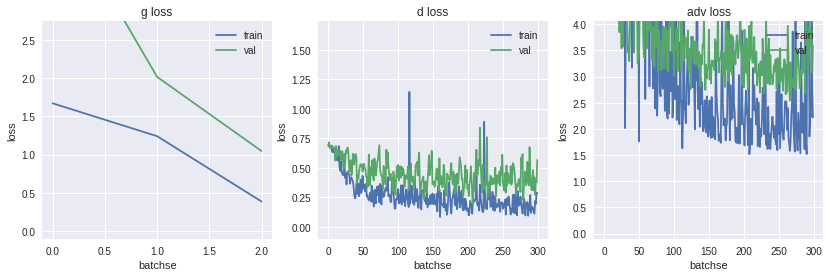

############################## epocs 4
0 of 75 small steps of size 10 please wait... 
20 of 75 small steps of size 10 please wait... 
40 of 75 small steps of size 10 please wait... 
60 of 75 small steps of size 10 please wait... 
############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<bbe>]: at the first times made the heaven and the earth . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
gold label     [<bbe>]: at the first god made the heaven and the earth .
decoder TF     [<ylt>]: at the first first the every life things earth was was earth . . <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> 

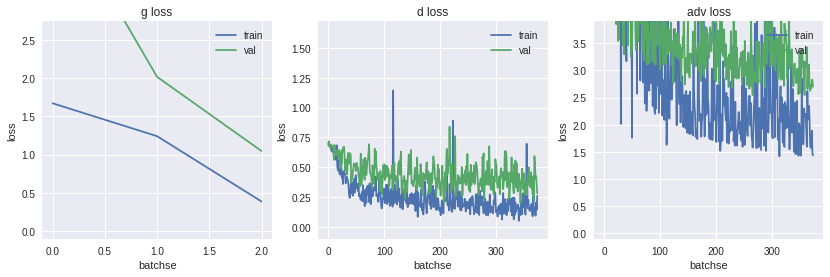

############################## epocs 5
0 of 75 small steps of size 10 please wait... 
20 of 75 small steps of size 10 please wait... 


In [0]:
print ('epoc contains ',epoc,'batches of', batch_size)
small_steps_d=1
small_steps_adv=10

for e in range(10):
  print ('#'*30,'epocs',e)
  for i in range(int(epoc/small_steps_adv)):
    if i%20 ==0:print (i,'of',int(epoc/small_steps_adv),'small steps of size',small_steps_adv,'please wait... ')
    #for j in range(10): #train d until it has a reasnbile value. or enough steps passed
    train_d(model.d,small_steps_d)
    #  l=loss_history_d.losses['loss'][-1:][0]
    #  if l<1.0:
    #    break
    train_adv(model.g_d,small_steps_adv)
  sampler.show_sample(dataset,'train'  ,sample_ids=[0,1],teacher_forcing=True)
  plt_all()
print ('done')

save=False
if (save):
  Persistency().save_weights(model.get_models(),model.get_model_names(),save_to_gdrive=False) #not run yet....
  


In [28]:
#train_adv(model.g_d,10000,1)

sampler.show_sample(dataset,'train'  ,sample_ids=[1],teacher_forcing=False)   #,8000+0
#train_g(model.g,100,1)


############################## verb 1 ##############################

##encoder_input[<bbe>]: and the earth was waste and without form ; and it was dark on the face of the deep : and the spirit of god was moving on the face of the waters .
decoder sample [<bbe>]: <bbe> <bbe> your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your your
gold label     [<bbe>]: and the earth was waste and without form ; and it was dark on the face of the deep : and the spirit of god was moving on the face of the waters .
decoder sample [<ylt>]: <ylt> <ylt> <ylt> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <O

# Error analysis

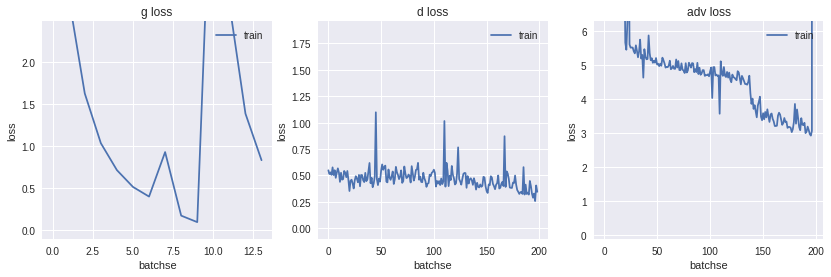

############################## verb 1 ##############################

##encoder_input[<bbe>]: and the earth was waste and without form ; and it was dark on the face of the deep : and the spirit of god was moving on the face of the waters .
decoder TF     [<bbe>]: the the of , , the , , and the the , , the the of the lord , the the lord , the , , , <end> <end> of the <end> , <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
gold label     [<bbe>]: and the earth was waste and without form ; and it was dark on the face of the deep : and the spirit of god was moving on the face of the waters .
decoder TF     [<ylt>]: the of the , , the , and the , the the , the of the lord , and the lord , the , , , lord of the lord , and <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end

In [34]:
#show_sample('test',sample_id=[0,1,2,999],teacher_forcing=False)   #,8000+0
#print (' VAL '*10)                          #TEst with FALSE
plt_all()
sampler.show_sample(dataset,'train'  ,sample_ids=[1],teacher_forcing=True)   #,8000+0

sampler.show_sample(dataset,'train'  ,sample_ids=[1],teacher_forcing=False)   #,8000+0


In [0]:
t

In [287]:



#a= model.predict([x_train[s:e], x_train_d[s:e]])
#for i in range(dataset.MAX_SEQUENCE_LENGTH):
#  best=np.argmax(a[0,i])
#  print (i,best,dataset.index2word[best],a[0,i,best],a[0,i,0])

#NEED TO FIX CODE HERE
from keras.losses import categorical_crossentropy
p=model.predict([x_val,x_val_d])
scores=K.eval(K.sum(categorical_crossentropy(K.constant(p), K.constant(y_val) ),axis=1))
worse_10 = scores.argsort()[::-1][:10]

for i in range(len(worse_10)):
  bad=worse_10[i]
  print (i,'arg',bad,'score',scores[bad],show_sample('val',False,bad))
  


ValueError: ignored

## Error of style disc.

In [211]:
### Error of style discriminator
x,y=next(gen(dataset.result.val,10,'d'))
print ('eval',d.evaluate(x,y))
p=d.predict(x)
for i in range(len(y)):
  print (i,'error',(abs(y[i][0]-p[i][0])),'gold',y[i],p[i],dataset.one_x_as_text(x[i]))





10/10 [==============================] - 0s 2ms/step
eval [0.6257959008216858, 0.8999999761581421]
0 actual 0.38546136 [0. 1.] [0.38546136 0.6145386 ] For I have kept the ways of the Lord; I have not been turned away in sin from my God.
1 actual 0.42803007 [0. 1.] [0.42803007 0.5719699 ] "And while she was still talking with the king, <oov> the prophet came in." <s> <s> <s> <s> <s> <s>
2 actual 0.31531385 [0. 1.] [0.31531385 0.6846862 ] "Then he gave a cry to the servant who was waiting on him and said, Put this woman out, and
3 actual 0.01998341 [1. 0.] [0.9800166  0.01998337] "And all the people come up after him, and the people are <oov> with <oov> and <oov> -- great joy,
4 actual 0.116271734 [0. 1.] [0.11627173 0.8837283 ] "Now the servants of David and <oov> had been out attacking a band of armed men, and they came back
5 actual 0.10636711 [0. 1.] [0.10636711 0.8936329 ] "He made them of liquid metal in the lowland of Jordan, at the way across the river, at <oov> between
6 actual 

# FAQ and wierd exceptions

* If you get exceptions related to cuda-lstm , inside the show_sample, but you actially not using it at all.  You will need to restart the notebook (thinking it's TF issue/bug)
* why the sampler without teacher-forcing emits garabage? if it emits the 1st word differently from teacher-forcing, it means that the models somehow got disconnected, or that you use wrong label (y1 should be one-hot of x1 not of x2)
* why the decoder shows bad sentences when my loss gets lower?  the loss should be **very** low before you start getting real results. typically values of g of less than 0.5

# New Section

In [1]:
#BUG IN GENERATOR TO RECREATE:
def time_g(new_gens,new_batches):
  for i in range(new_gens):
    if i%10==0 : print (i)
    #WORKS ON TRAIN g_adv = dataset.gen_adv(dataset.train, batch_size)
    g_adv = dataset.gen_adv(dataset.val, batch_size)
    for _ in range(new_batches):
      [x1,x2],[y1,y2] = next(g_adv)
      #print (x1.shape)
%time time_g(500,5) #100 in 2.77 s (slowwwwwwwwwwwwwwwwwww)







NameError: ignored

In [0]:
# Very slow training speed, is it generator next() which is slow?
%time gen= dataset.gen_adv(dataset.train, batch_size)
%time next(gen)
%time next(gen)
%time next(gen)
[x1,x2],[y1,y2]=next(gen)
print (x1.shape)  #20 batches per second

#for i in range(100): #batch-generation time is up to 50ms. means 10 batches is 0.5 seconds, means train step is 1sec only generation!
train_adv(model.g_d, 1000, validation_steps=1) #looked like 2-3min 180s, of which 100s are 

In [118]:
from termcolor import colored
import numpy as np

class SamplingDecoder():
    """
      init it with encoder_model and decoder_sampling_model
      It will be used to sample results(currently greedy)
    """

    def __init__(self, model_g_d):
        self.model_g_d = model_g_d

    # TODO: now it's greedy and use argmax
    # maybe to choose randomly by distribution
    # and maybe to implement BEAM SEARCH
    def decode_sequence(self, input_seq, style_token, max_decoder_seq_length, end_symbol, verbose=False):
        """ input_seq as array of tokens of shape 1,SIZE why? TODO: fix
            style  as string  ('<bbe>')
        """
        if len(input_seq.shape) == 1:
            print ('reshaping')
            input_seq = input_seq.reshape(1, -1)  # now it's 1,N

        if verbose: print('input_seq', input_seq.shape, input_seq[0])
        # Encode the input as state vectors.
        states_value = self.model_g_d.encoder_model.predict(input_seq)
        if verbose: print('encoder result states_value', 'h', states_value[0].shape, states_value[0].mean(), 'c',
                          states_value[1].shape, states_value[1].mean())

        # Generate empty target sequence of length 1.
        #                      batch,word-number value is token (0 /122)
        target_seq = np.zeros((1, 1))
        # Populate the first character of target sequence with the start character.
        target_seq[0, 0] = style_token
        if verbose: print('target_seq', target_seq)

        # Sampling loop for a batch of sequences
        # (to simplify, here we assume a batch of size 1).
        stop_condition = False
        decoded_sentence = []
        while not stop_condition:
            # start with encoder-state then change to self state
            output_tokens, h, c = self.model_g_d.decoder_sampling_model.predict([target_seq] + states_value)
            if verbose:
                #print('output_tokens', output_tokens.shape, output_tokens.mean(), 'h', h.shape, 'c', c.shape)
                #print('output softmax, first 10', output_tokens[0, 0, :10])
                pass

            # Sample a token
            sampled_token_index = np.argmax(output_tokens)  # [0, -1, :])
            #if verbose: print('sampled_token_index', sampled_token_index.shape, output_tokens.max(), sampled_token_index)
            decoded_sentence.append(sampled_token_index)

            # Exit condition: either hit max length
            # or find stop character.
            if (sampled_token_index == end_symbol or
                        len(decoded_sentence) > max_decoder_seq_length):
                stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

            # Update states
            states_value = [h, c]

        res = np.array(decoded_sentence)  # [dataset.index2word[index] for index in decoded_sentence]
        return res

    def show_sample(self, dataset, data_type='val', sample_ids=[], teacher_forcing=False):
        """
          data_type - train/val/test
          teacher_forcing : default False, sample argmax as for normal test. If true, feed decode-input from the dataset itself
          sample_ids : verse-id to sample (list)
          replace_style: if true, will pass a different style
        """
        styles = ['<bbe>', '<ylt>']
        # corp1 = dataset.corpora['<bbe>']
        # corp2 = dataset.corpora['<ylt>']
        # data1={'train': corp1[dataset.train[0]:dataset.train[1]], 'val':corp1[dataset.val[0]:dataset.val[1]] , 'test':corp1[dataset.test[0]:dataset.test[1]]}
        # data2={'train': corp2[dataset.train[0]:dataset.train[1]], 'val':corp2[dataset.val[0]:dataset.val[1]] , 'test':corp2[dataset.test[0]:dataset.test[1]]}

        for i in sample_ids:
            print('#' * 30, 'verb', i, '#' * 30)

            if data_type == 'train':
                r = dataset.train
            elif data_type == 'val':
                r = dataset.val
            else:
                r = dataset.test

            start, end = r[0], r[1]

            for style in styles:
                sentence = dataset.corpora[style][start:end][i]
                print(f'\n##encoder_input[{style}]:', dataset.recostruct_sentence(sentence))

                # decode it in every possible style, by replacing style
                one_x = dataset.enc_input([dataset.pad_sentence(sentence, dataset.max_sentence_length)]).reshape(1,-1)
                one_x_d = dataset.dec_input([dataset.pad_sentence(sentence, dataset.max_sentence_length)],[style]).reshape(1, -1)

                for replaced_style in styles:
                    # always replace_style:

                    gold_label = dataset.corpora[replaced_style][start:end][i]

                    if teacher_forcing:
                        one_x_d = dataset.dec_input([dataset.pad_sentence(gold_label, dataset.max_sentence_length)],
                                                    [replaced_style]).reshape(1, -1)
                        # print ('encoder get:',one_x[0][:10])
                        # print ('tf get:',one_x_d[0][:10] )

                        p = self.model_g_d.g.predict([one_x, one_x_d[:]])
                        p = p[0].argmax(axis=1)
                        # print ('argmax:',p)
                        print ('into ',dataset.recostruct_sentence(one_x_d[0]))
                        print(colored(f'decoder TF     [{replaced_style}]: {dataset.recostruct_sentence(p[:])}',
                                      'red'))  # skip first token of style
                    else:
                        # print (one_x)
                        max_decoder_seq_length = dataset.max_sentence_length + 1  # always pad one
                        p = self.decode_sequence(one_x, dataset.word2index[replaced_style], max_decoder_seq_length,dataset.word2index[dataset.end_symbol() ], verbose=True)
                        print(f'decoder sample [{replaced_style}]:', dataset.recostruct_sentence(p))

                    print(f'gold label     [{replaced_style}]:', dataset.recostruct_sentence(gold_label))
                    
train_g(model.g,500,validation_steps=1) 
#sampler= SamplingDecoder(model)          
#sampler.show_sample(dataset,'train',sample_ids=[0],teacher_forcing=True)           
#sampler.show_sample(dataset,'train',sample_ids=[0],teacher_forcing=True)           
                   


Epoch 1/1
500/500 [==============================] - 56s 113ms/step - loss: 3.0854 - val_loss: 3.7252


In [70]:
sampler= SamplingDecoder(model)          
sampler.show_sample(dataset,'train',sample_ids=[0],teacher_forcing=False)           
#sampler.show_sample(dataset,'train',sample_ids=[0],teacher_forcing=True)           
train_g(model.g,1000,validation_steps=100)  

############################## verb 0 ##############################

##encoder_input[<bbe>]: at the first god made the heaven and the earth .
input_seq (1, 61) first 10 [ 239 3171 1157 1332 1933 3171 1467  142 3171  952]
encoder result states_value h (1, 256) -0.004604909 c (1, 256) -0.031092346
target_seq [[3624.]]
decoder sample [<bbe>]: <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe> <bbe>
gold label     [<bbe>]: at the first god made the heaven and the earth .
input_seq (1, 61) first 10 [ 239 3171 1157 1332 1933 3171 1467  142 3171  952]
encoder result states_value h (1, 256) -0.004604909 c (1, 256) -0.031092346
target_seq [[3627.]]
decoder sample [<ylt>]: <ylt> <ylt> 

1000/1000 [==============================] - 148s 148ms/step - loss: 0.0317 - val_loss: 0.0967
